In [16]:
# Importing libraries
from data_driven.modeling.scripts.tuning import rfc_parameter_tuning
from data_driven.modeling.scripts.ancillary import (drive_authentication, npz_files, open_dataset,
                                                    cv_and_y_random, save_best_params,
                                                   rfc_draw_convergence)
from data_driven.modeling.scripts.evaluation import performing_cross_validation
from data_driven.modeling.scripts.metrics import prediction_evaluation

%matplotlib inline
from skopt.space import Integer, Categorical
import pandas as pd
import time
from sklearn.metrics import plot_confusion_matrix
import pickle
import os
import matplotlib.pyplot as plt

# 1. Accessing the data 

If you will use Google Drive, you have to enable Google Drive and obtain the client secrets file client_secrets.json (see the following [link](https://developers.google.com/drive/api/v3/enable-drive-api) or [this other](https://www.geeksforgeeks.org/get-list-of-files-and-folders-in-google-drive-storage-using-python/))

In [2]:
# Connecting to Google Drive
# client_secrets.json need to be in the same directory as the script

drive = drive_authentication()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=128273080156-gak8id4v61mj7jjdqqucv74kc5volhj0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


If you need to check the folder on where you have stored the data for running the multi-class classification algorithm, use the folder ID and the function just below

In [3]:
# When you share a folder/file from Google Drive by using its shareable link you will see tomething like 
# https://drive.google.com/drive/folders/{ID_element}?usp=sharing. You can take the ID_element

multi_class_data_folder_id = '1hoUT3WQxblQJWm-8v-9EKLJZ4614JVtI'
ids = npz_files(multi_class_data_folder_id, drive)
ids

{'3': '18KrIiGmRn90uCNchktAWDPRa8wl2qKyO',
 '2': '1pAgEm3u5_spuniqBBfFta3EK2xPuLQc3',
 '1': '1bGA6Zuvez9weG0sZglM6nFpphSMjdl8D'}

# 2. Building RFC with default parameters

In [4]:
# Default parameters
model_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 200,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [5]:
df_results = pd.DataFrame()

for id, key in ids.items():
    
    print(f'Evaluating base model for data preparation id {id}\n')
    
    # Opening the dataset
    X_train, Y_train = open_dataset(id, key, drive, test=False)
    
    # Y-randomization and cross-validation
    df_results = pd.concat([df_results,
                            cv_and_y_random(id, X_train, Y_train.reshape(Y_train.shape[0],),
                                            model_params, 'RFC', 'multi-class classification',
                                            threshold=0.75
                                            )
                           ],
                          axis=0,
                          ignore_index=True)

Evaluating base model for data preparation id 3

X train has the following dimensions: (486440, 83)
Y train has the following dimensions: (486440, 1)


Y-Randomization: 100%|██████████| 10/10 [07:37<00:00, 45.79s/it]


Evaluating base model for data preparation id 2

X train has the following dimensions: (486440, 79)
Y train has the following dimensions: (486440, 1)


Y-Randomization: 100%|██████████| 10/10 [07:05<00:00, 42.56s/it]


Evaluating base model for data preparation id 1

X train has the following dimensions: (59070, 62)
Y train has the following dimensions: (59070, 1)


Y-Randomization: 100%|██████████| 10/10 [02:37<00:00, 15.77s/it]


In [6]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id
0,0.45,0.80,over-fitting (high variance),0.44,0.80,0.55,0.001079,0.9,0.000805,3
1,0.45,0.80,over-fitting (high variance),0.44,0.80,0.55,0.001765,0.9,0.001071,2
2,0.40,0.77,over-fitting (high variance),0.40,0.77,0.60,0.003945,0.9,0.003369,1


# 3. Selection of best data preprocessing

Model performance, explainability, and time are three important factors to be considered.

1. Explainability: from the point of view of the model, as the three pipelines use RFC, the explainability depends on the features. FAMD reduces the dimensionality by transforming the original features into new orthogonal ones. Thus, it is not possible to make inferences directly about the importance of the original feature.
2. Performance: as shown in the above results, the default RFC presents overfitting for the three preprocessing pipelines and their performances are similar, with the pipeline id 1 a little worse than the others.
3. Time: for Y randomization and cross validation, the pipeline id 1 required around 208 seconds. Nonetheless, the ratio between time and samples for pipeline 2 is the lowest (around 0.00127 sec/samples). This pepilene could represent the lower time per sample for tuning and prediction for serving models, considering that the pipeline 1 that uses FAMD will require additional time in order to transform the original feature to the new feature space.

Thus, it is not complicated to decide for its performance, time for processing a sample, and explainability to select the pipeline id 2.



Reducing the parameters like n_estimators, max_features, and max_depth and increasing parameters like min_samples_leaf and min_samples_split are more likely to reduce the overfitting for a RFC.

In [34]:
# Parameters with lower max_depth
model_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 25,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 50,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}


# Opening the dataset
X_train, Y_train = open_dataset('2', '1pAgEm3u5_spuniqBBfFta3EK2xPuLQc3', drive, test=False)

# Y-randomization and cross-validation
cv_and_y_random('2', X_train, Y_train.reshape(Y_train.shape[0],),
                            model_params, 'RFC', 'multi-class classification',
                            threshold=0.75)

X train has the following dimensions: (486440, 79)
Y train has the following dimensions: (486440, 1)


Y-Randomization: 100%|██████████| 10/10 [02:11<00:00, 13.11s/it]


,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id
0,0.47,0.73,under-fitting (high bias and high variance),0.45,0.73,0.53,0.001469,0.9,0.000664,2


As shown by the above test, reducing max_depth may help to reduce overfitting by increasing the model bias. The above point will be used as the starting point for the model tuning.

# 4. Tuning the model

In [4]:
# Opening the dataset
X_train, Y_train, X_test, Y_test = open_dataset('2', '1pAgEm3u5_spuniqBBfFta3EK2xPuLQc3', drive, test=True)

X train has the following dimensions: (486440, 79)
Y train has the following dimensions: (486440, 1)
X test has the following dimensions: (67159, 79)
Y test has the following dimensions: (67159, 1)


In [5]:
# Fixed parameters
model_params = {
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [6]:
# For tuning
search_space = [Integer(1, 50, name='min_samples_leaf'),
                Integer(2, 50, name='min_samples_split'), 
                Categorical(['log2', 'sqrt'], name='max_features'),
                Integer(10, 100, name='n_estimators'),
                Integer(5, 200, name='max_depth'),
                Categorical(['gini', 'entropy'], name='criterion'),
                Categorical([True, False], name='bootstrap')]

In [7]:
# Initial points

x_initial = {'min_samples_leaf': 1,
            'min_samples_split': 2,
            'max_features': 'sqrt',
            'n_estimators': 50,
            'max_depth': 25,
            'criterion': 'gini',
            'bootstrap': True}
y_initial = -0.45

In [11]:
# Tuning
# We run Bayesian Optimization with Gaussian Processes, which uses a Multidimensional Gaussian distribution as surrogate model.
# The objective function is the negative of the the mean f1 score for 5-fold cross-validation
# A threshold of 0.75 for the f1 score to stop the optimization is used
# n_iter_search = number of iterations for the Bayesian Optimization
# time_to_optimize = the budget time to optimize the Bayesian Optimization

start = time.time()

tuning_result = rfc_parameter_tuning(X_train, Y_train.reshape(Y_train.shape[0],),
                                'multi-class classification',
                                model_params, search_space,
                                time_to_optimize=14400,
                                n_calls=200,
                                threshold=0.75, 
                                verbose=True,
                                x_initial=x_initial,
                                y_initial=y_initial,
                                n_initial_points=5)

end = time.time()

best_params = {'model': {
                    'RFC': {'params': {**tuning_result['best_params'], **model_params}
                           }
                        }
              }

# Saving the best parameters
save_best_params('multi-class classification', best_params)

print(f'The minimum for the objective function is {tuning_result["best_objective"]}')
print(f'The time actually spent for tuning {end - start} seconds')  

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.2773
Function value obtained: -0.4500
Current minimum: -0.4500
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 892.9520
Function value obtained: -0.3900
Current minimum: -0.4500
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 105.6757
Function value obtained: -0.4200
Current minimum: -0.4500
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 31.5891
Function value obtained: -0.2600
Current minimum: -0.4500
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 114.9829
Function value obtained: -0.4300
Current minimum: -0.4500
Iteration No: 6 s

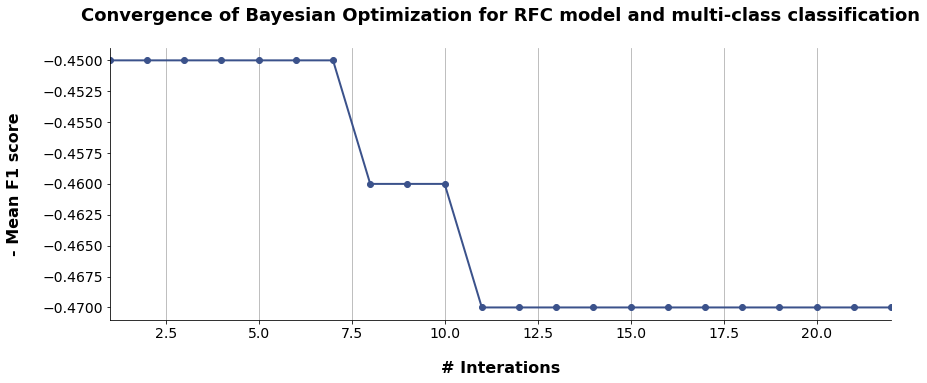

In [12]:
# Convergence drawing

rfc_draw_convergence(tuning_result, 'multi-class classification')

In [13]:
# cross-validation with the found hyperparameters

path_pickle = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'models',
                        'multi-class classification'.replace(' ', '_'),
                        'RFC_best_params.pkl')

with open(path_pickle, 'rb') as inputfile:
    best_params = pickle.load(inputfile)['model']['RFC']['params']

# Y-randomization and cross-validation
cv_result, classifier = performing_cross_validation('RFC', best_params,
                                                    X_train, Y_train.reshape(Y_train.shape[0],),
                                                    'multi-class classification',
                                                    for_tuning=False, threshold=0.75,
                                                    return_model=True)

5-fold cross validation: 100%|██████████| 5/5 [18:28<00:00, 221.66s/it]


In [14]:
pd.DataFrame({key: [val] for key, val in cv_result.items()})

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error
0,0.49,0.57,under-fitting (high bias and high variance),0.46,0.55,0.51,0.001359


In [19]:
# External evaluation

Y_test_hat = classifier.predict(X_test)

print(f'Test accuracy is {prediction_evaluation(Y_test.reshape(Y_test.shape[0],), Y_test_hat)}')
print(f'Test f1 score is {prediction_evaluation(Y_test.reshape(Y_test.shape[0],), Y_test_hat, metric="f1")}')

Test accuracy is 0.29439092303339837
Test f1 score is 0.24484238634542604


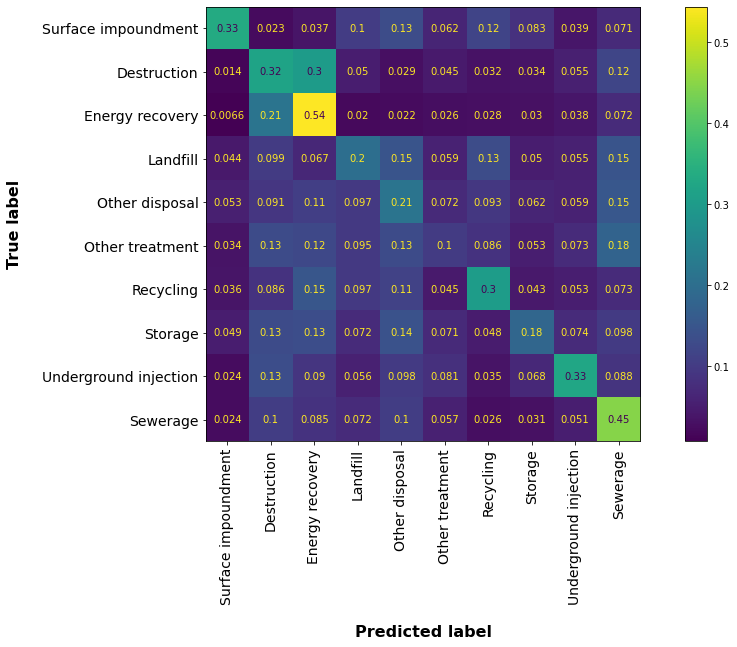

In [15]:
# Confusion matrix

fig, ax = plt.subplots(figsize=(16,8))

plot_confusion_matrix(classifier, X_test, Y_test, ax=ax, normalize='true',
                    display_labels=['Surface impoundment', 'Destruction', 'Energy recovery',
                                    'Landfill', 'Other disposal', 'Other treatment',
                                    'Recycling', 'Storage', 'Underground injection', 'Sewerage'])

# axis labels
ax.set_ylabel('True label', fontsize=16, fontweight='bold', labelpad=20)
ax.set_xlabel('Predicted label', fontsize=16, fontweight='bold', labelpad=20)
plt.xticks(rotation=90)

# Y ticks fontsize
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# X ticks fontsize
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Save the plot
path_plot = os.path.join(os.getcwd(),
                        os.pardir, os.pardir,
                        'output', 'figures',
                        'multi-class classification'.replace(' ', '_'),
                        'RFC_confusion_matrix.pdf')
plt.savefig(path_plot, dpi=fig.dpi, bbox_inches='tight')

The above figure shows that the RFC cannot find the decision boundary properly. It could be due to the fact that the labels are not mutually exclusive. For example, 21% of the labels actually for energy recovery are classified as destruction, and similarly, 30% of the labels that are actually destruction are misclassified as energy recovery. It is possible that the use of an ANNC model may not help to resolve the problem of mutually non exclusive labels.